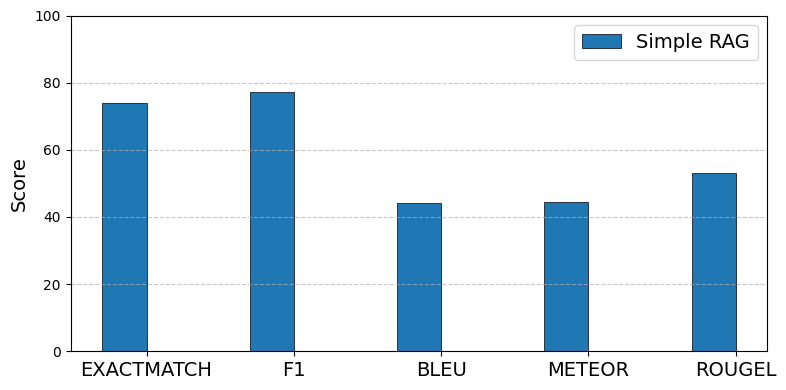

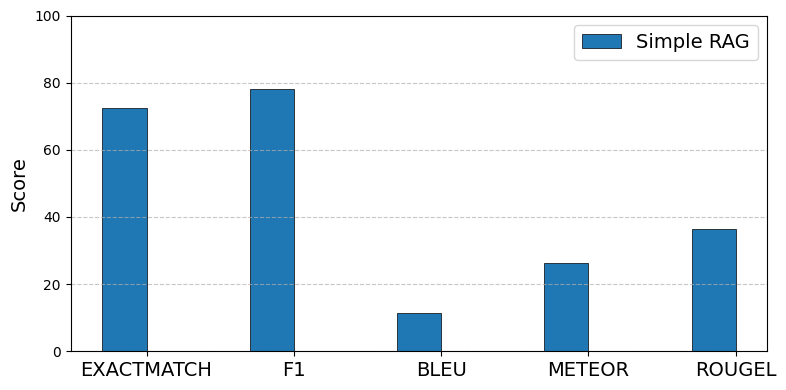

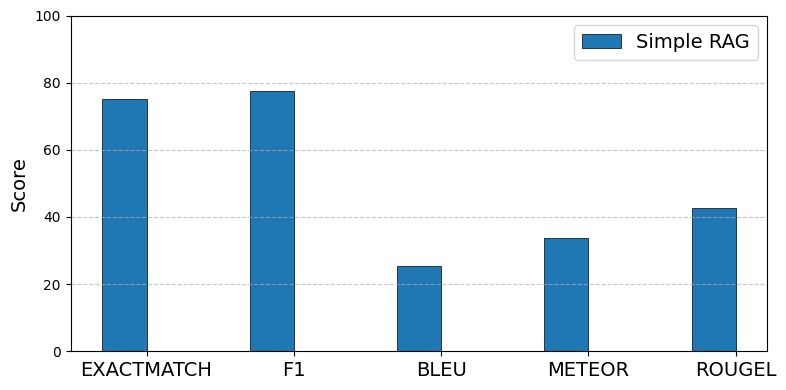

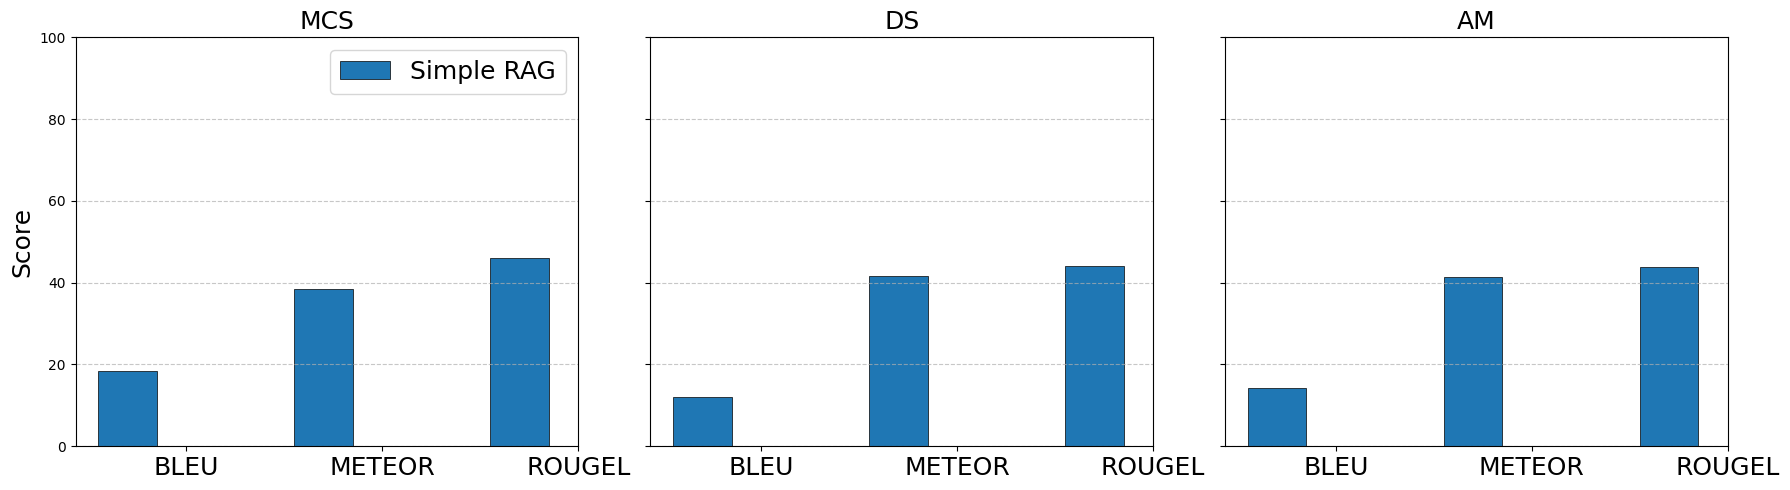

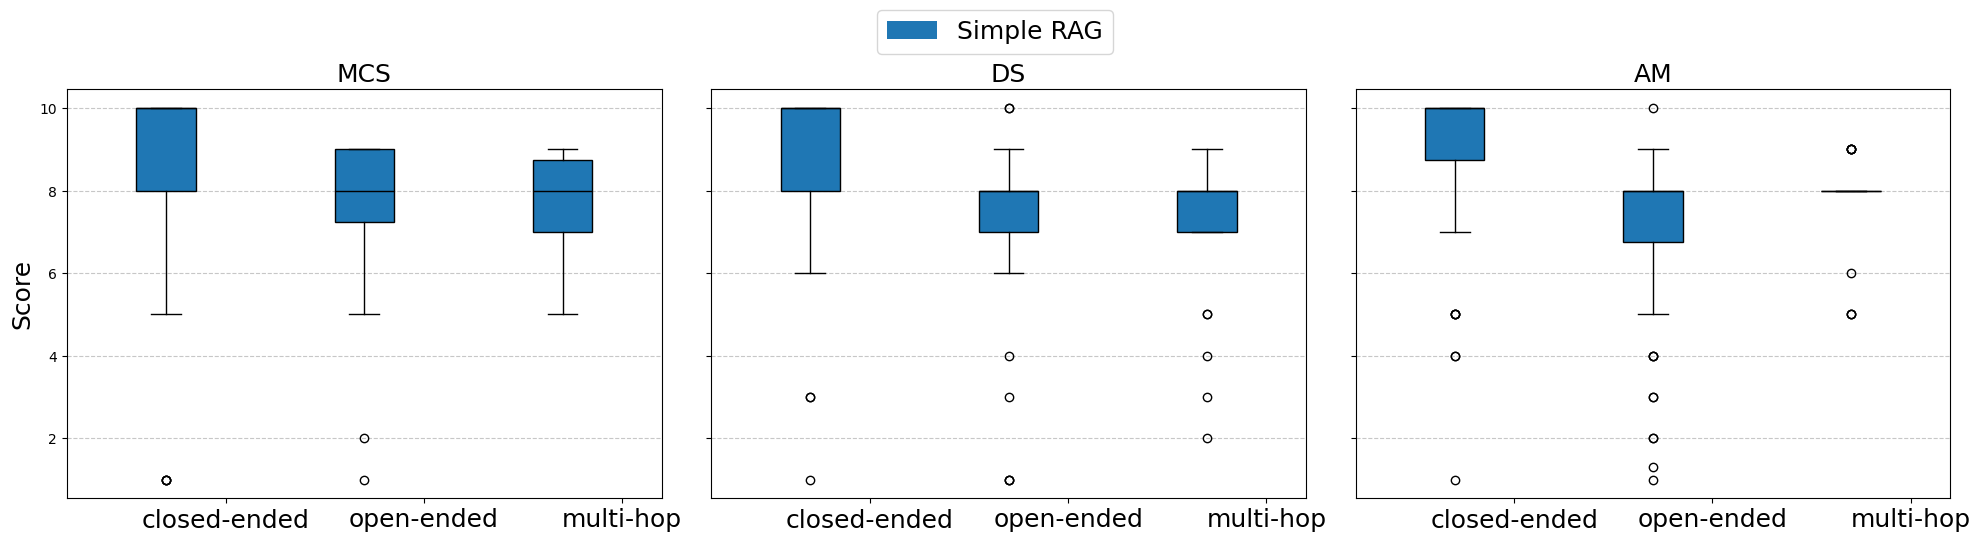

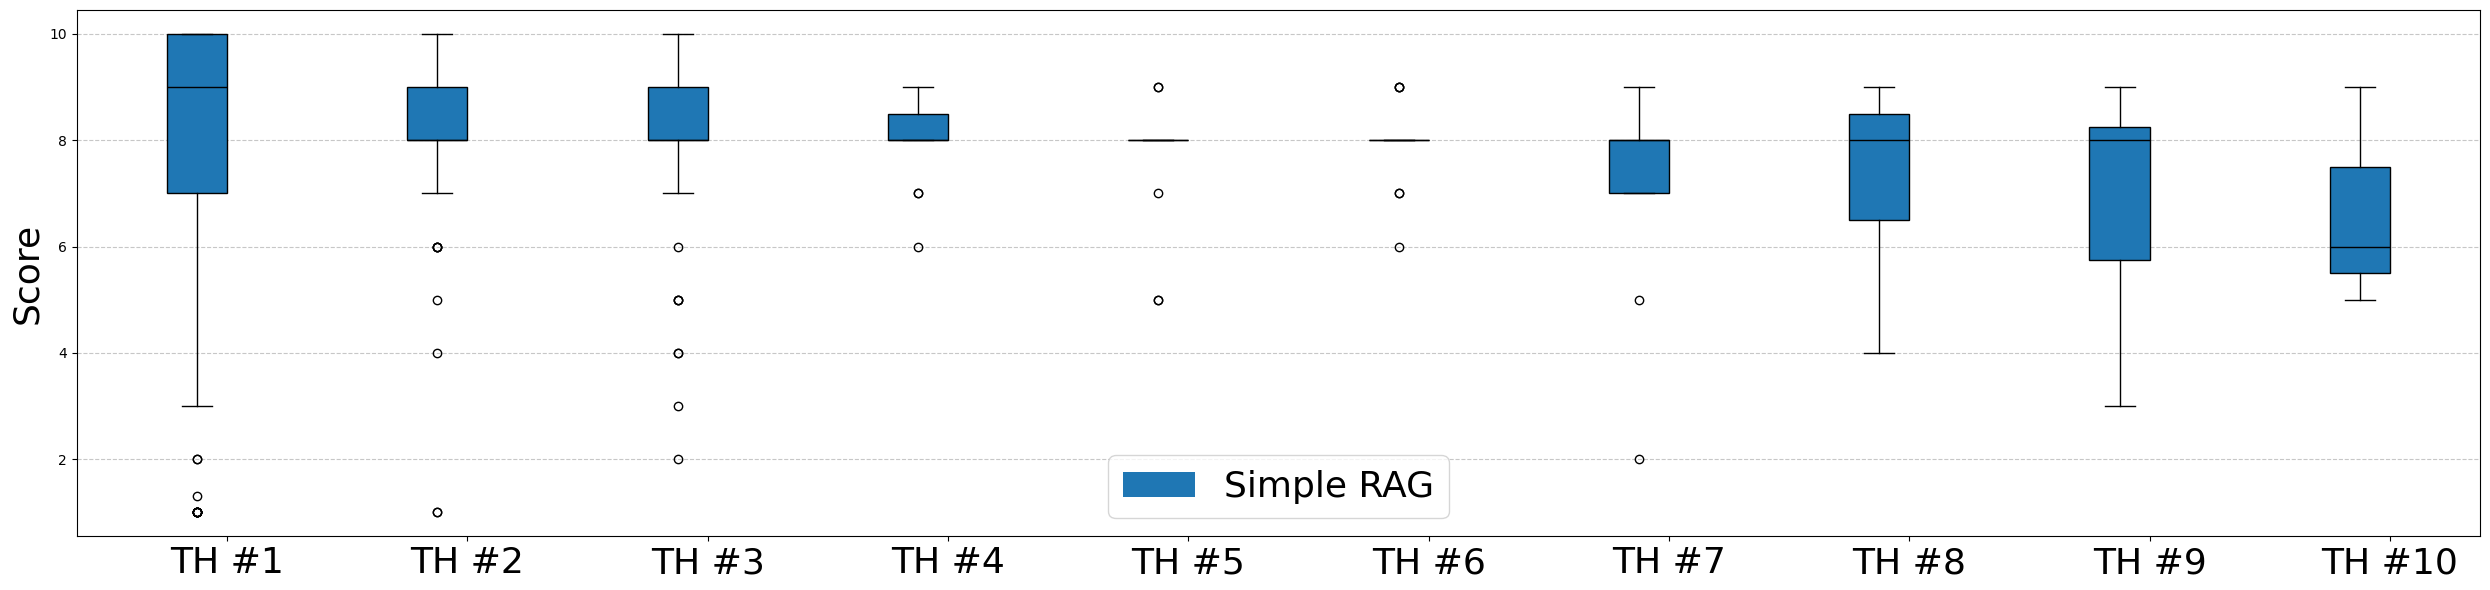

In [53]:
import pandas as pd
import numpy as np
import os
import json
from matplotlib import pyplot as plt

# ✅ Corrected relative path to match actual directory structure
tmpl_dirpath = "output_logs/{major}_{kind_of_qa}_{postfix}"
majors = ["MCS", "DS", "AM"]
postfixes = ["hcmus_contriever_standard_rag"]
kinds_of_qa = ["closed_end", "opened_end", "multihop2"]

# Step 1: Extract and save recall@k metrics
for major in majors:
    retrieval_tables = []
    for postfix in postfixes:
        tmp = {"method": postfix}
        for kind_of_qa in kinds_of_qa:
            dirpath = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
            results_fpath = os.path.join(dirpath, "results.json")
            if not os.path.exists(results_fpath):
                print(f"⚠️ Missing: {results_fpath}, skipping...")
                continue
            with open(results_fpath, "r", encoding="utf-8") as f:
                results = json.load(f).get('retrieval', {})
            tmp.update({f"{kind_of_qa}:{k}": v for k, v in results.items()})
        retrieval_tables.append(tmp)
    retrieval_df = pd.DataFrame(retrieval_tables)
    required_cols = [f"{qa}:Recall@{k}" for qa in kinds_of_qa for k in [1, 2, 5]]
    if not all(col in retrieval_df.columns for col in required_cols):
        print(f"⚠️ Skipping {major}: Missing Recall@k columns.")
        continue
    for col in required_cols:
        retrieval_df[col] = retrieval_df[col].astype(float)
    retrieval_df["Recall@1"] = retrieval_df[[f"{qa}:Recall@1" for qa in kinds_of_qa]].mean(axis=1)
    retrieval_df["Recall@2"] = retrieval_df[[f"{qa}:Recall@2" for qa in kinds_of_qa]].mean(axis=1)
    retrieval_df["Recall@5"] = retrieval_df[[f"{qa}:Recall@5" for qa in kinds_of_qa]].mean(axis=1)
    retrieval_df.to_csv(f"../results/{major}_retrieval.csv", index=False, float_format="%.3f", sep="&")


# Step 2: Generate bar charts comparing methods per major for closed/opened QA
fontsize = 14
for major in majors:
    radar_results = []
    # Only use available postfix since we only have contriever data
    selected_postfixes = ["hcmus_contriever_standard_rag"]
    for postfix in selected_postfixes:
        method_name = "Simple RAG" if "standard_rag" in postfix else "Graph-based RAG"
        results = {"method": method_name}
        for kind_of_qa in ["closed_end", "opened_end"]:
            dirpath = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
            results_fpath = os.path.join(dirpath, "results.json")
            if not os.path.exists(results_fpath):
                print(f"⚠️ Missing: {results_fpath}, skipping...")
                continue
            tmp = json.load(open(results_fpath, "r", encoding="utf-8"))
            if kind_of_qa == 'closed_end':
                tmp_results = tmp['closed_ended']
                tmp_results = {k.upper(): float(v) * 100 for k, v in tmp_results.items()}  # Convert to percentage
            else:
                tmp_results = tmp['open_ended']
                tmp_results = {k.upper(): float(v) for k, v in tmp_results.items()}  # Already in percentage
            results.update(tmp_results)
        radar_results.append(results)
    df = pd.DataFrame(radar_results).set_index('method')
    df_T = df.transpose()
    fig, ax = plt.subplots(figsize=(8, 4))
    for i, method in enumerate(df_T.columns):
        ax.bar(np.arange(len(df_T.index)) + i * 0.3, df_T[method], width=0.3, label=method, edgecolor='black', linewidth=0.5)
    ax.set_xticks(np.arange(len(df_T.index)) + 0.3 / 2)
    ax.set_xticklabels(df_T.index, fontsize=fontsize)
    ax.set_ylabel('Score', fontsize=fontsize)
    ax.set_ylim(0, 100)
    ax.legend(ncols=1, fontsize=fontsize)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"../results/{major}_qa_bar_chart.pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Step 3: Multihop chart subplot
fontsize = 18
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for idx, major in enumerate(majors):
    radar_results = []
    # Only use available postfix since we only have contriever data
    selected_postfixes = ["hcmus_contriever_standard_rag"]
    for postfix in selected_postfixes:
        method_name = "Simple RAG" if "standard_rag" in postfix else "Graph-based RAG"
        results = {"method": method_name}
        dirpath = tmpl_dirpath.format(major=major, kind_of_qa="multihop2", postfix=postfix)
        results_fpath = os.path.join(dirpath, "results.json")
        if not os.path.exists(results_fpath):
            print(f"⚠️ Missing: {results_fpath}, skipping...")
            continue
        tmp_results = json.load(open(results_fpath, "r", encoding="utf-8"))["open_ended"]
        results.update({k.upper(): float(v) for k, v in tmp_results.items()})  # Already in percentage
        radar_results.append(results)
    df = pd.DataFrame(radar_results).set_index('method').transpose()
    ax = axes[idx]
    for i, method in enumerate(df.columns):
        ax.bar(np.arange(len(df.index)) + i * 0.3, df[method], width=0.3, label=method, edgecolor='black', linewidth=0.5)
    ax.set_xticks(np.arange(len(df.index)) + 0.3)
    ax.set_xticklabels(df.index, fontsize=fontsize)
    ax.set_title(major, fontsize=fontsize)
    ax.set_ylim(0, 100)
    if idx == 0:
        ax.set_ylabel("Score", fontsize=fontsize)
        ax.legend(fontsize=fontsize)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("../results/qa_bar_chart_multihop.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Step 4: Boxplot per QA type
fontsize = 18
dfs = []
for major in majors:
    # Only use available postfix since we only have contriever data
    selected_postfixes = ["hcmus_contriever_standard_rag"]
    records = []
    for postfix in selected_postfixes:
        method_name = "Simple RAG" if "standard_rag" in postfix else "Graph-based RAG"
        for kind_of_qa in kinds_of_qa:
            path = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
            results_fpath = os.path.join(path, "results.json")
            if not os.path.exists(results_fpath):
                print(f"⚠️ Missing: {results_fpath}, skipping...")
                continue
            scores = json.load(open(results_fpath, "r", encoding="utf-8"))["gpt_judgement"]
            for score in scores:
                # Handle multiple formats: "8", "Score: 8", "1. 3", etc.
                if isinstance(score, str):
                    if score.startswith("Score: "):
                        score_value = float(score.replace("Score: ", ""))
                    elif ". " in score:  # Handle "1. 3" format
                        score_value = float(score.replace(". ", "."))
                    else:
                        score_value = float(score)
                else:
                    score_value = float(score)
                records.append({'method': method_name, 'QA Type': kind_of_qa, 'Score': score_value})
    dfs.append(pd.DataFrame(records))

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
colors = plt.get_cmap('tab10').colors
for idx, (df, ax, major) in enumerate(zip(dfs, axes, majors)):
    methods = df['method'].unique()
    for i, method in enumerate(methods):
        pos = [1 + i*0.3, 2 + i*0.3, 3 + i*0.3]
        data = [
            df[(df['method'] == method) & (df['QA Type'] == qa)]['Score']
            for qa in ['closed_end', 'opened_end', 'multihop2']
        ]
        ax.boxplot(data, positions=pos, widths=0.3, patch_artist=True,
                   boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black'))
    ax.set_xticks([1 + 0.3, 2 + 0.3, 3 + 0.3])
    ax.set_xticklabels(['closed-ended', 'open-ended', 'multi-hop'], fontsize=fontsize)
    ax.set_title(major, fontsize=fontsize)
    if idx == 0:
        ax.set_ylabel('Score', fontsize=fontsize)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.legend([
    plt.Rectangle((0,0),1,1,facecolor=colors[i]) for i in range(len(methods))
], methods, loc='upper center', ncol=2, fontsize=fontsize, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
plt.savefig("../results/gpt4_judgement_boxplot.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Step 5: Per-case study analysis boxplot
fontsize = 26
case_std_results = {f"TH #{i}": {"Simple RAG": [], "Graph-based RAG": []} for i in range(1, 11)}
for major in majors:
    # Only use available postfix since we only have contriever data
    selected_postfixes = ["hcmus_contriever_standard_rag"]
    for postfix in selected_postfixes:
        method_name = "Simple RAG" if "standard_rag" in postfix else "Graph-based RAG"
        for kind_of_qa in kinds_of_qa:
            path = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
            results_fpath = os.path.join(path, "results.json")
            if not os.path.exists(results_fpath):
                print(f"⚠️ Missing: {results_fpath}, skipping...")
                continue
            scores = json.load(open(results_fpath, "r", encoding="utf-8"))["gpt_judgement"]
            qa_data_fpath = f"../QA for testing/{major}/{major}_{kind_of_qa}.json"
            if not os.path.exists(qa_data_fpath):
                print(f"⚠️ Missing: {qa_data_fpath}, skipping...")
                continue
            qa_df = pd.DataFrame(json.load(open(qa_data_fpath, "r", encoding="utf-8")))
            for i in range(1, 11):
                idxs = qa_df[qa_df['case_std_id'] == i].index
                case_scores = []
                for j in idxs:
                    # Handle multiple formats: "8", "Score: 8", "1. 3", etc.
                    score = scores[j]
                    if isinstance(score, str):
                        if score.startswith("Score: "):
                            score_value = float(score.replace("Score: ", ""))
                        elif ". " in score:  # Handle "1. 3" format
                            score_value = float(score.replace(". ", "."))
                        else:
                            score_value = float(score)
                    else:
                        score_value = float(score)
                    case_scores.append(score_value)
                case_std_results[f"TH #{i}"][method_name].extend(case_scores)

fig, ax = plt.subplots(figsize=(2.5*10, 6))
colors = ['#1f77b4', '#ff7f0e']
for i, cs in enumerate(case_std_results):
    for j, method in enumerate(methods):
        ax.boxplot(case_std_results[cs][method], positions=[i + j*0.25], widths=0.25,
                   patch_artist=True, boxprops=dict(facecolor=colors[j]), medianprops=dict(color='black'))
ax.set_xticks([i + 0.125 for i in range(10)])
ax.set_xticklabels(case_std_results.keys(), fontsize=fontsize)
ax.set_ylabel('Score', fontsize=fontsize)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend([plt.Rectangle((0,0),1,1,facecolor=c) for c in colors], methods, loc='lower center', ncol=2, fontsize=fontsize)
plt.tight_layout()
plt.savefig("../results/case_study_grouped_boxplot.pdf", dpi=300, bbox_inches='tight')
plt.show()


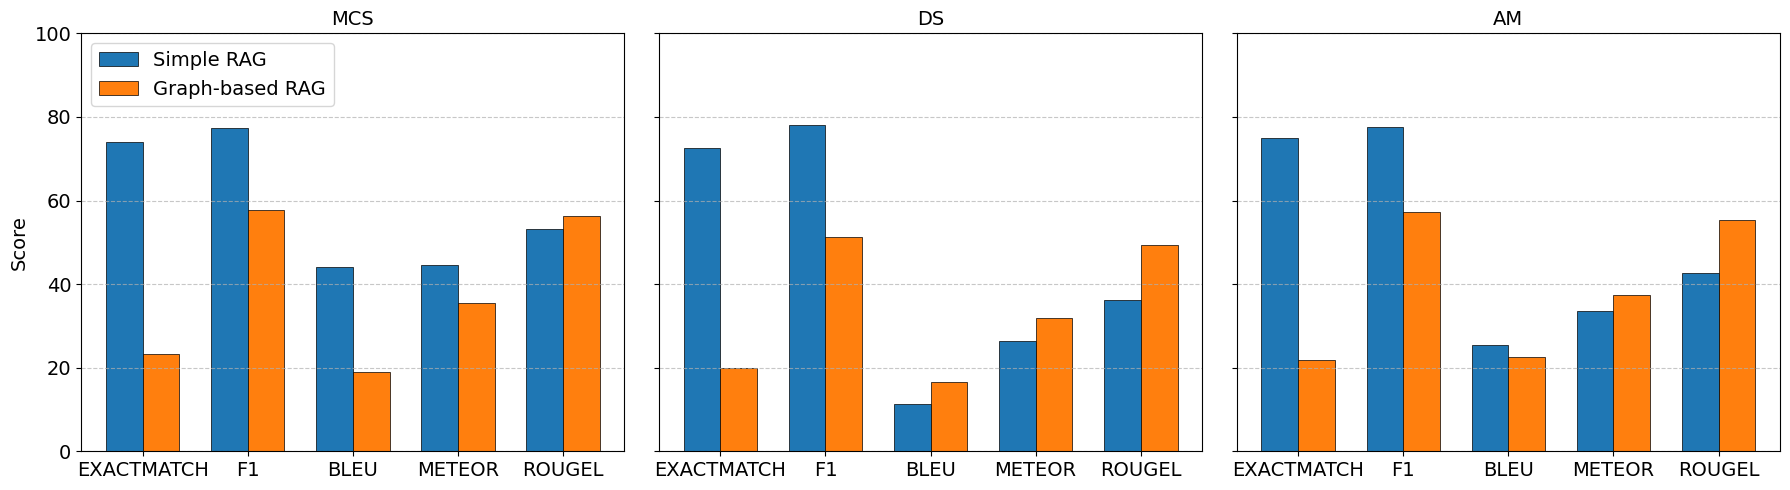

In [7]:
import pandas as pd
import numpy as np
import os
import json
from matplotlib import pyplot as plt

# Định nghĩa mapping và thứ tự metric CHUẨN
metric_map = {
    "EXACTMATCH": "Exact_Match",
    "F1": "F1_Score",
    "BLEU": "BLEU",
    "METEOR": "METEOR",
    "ROUGEL": "ROUGE_L"
}
metric_order = list(metric_map.keys())  # ["EXACTMATCH", "F1", "BLEU", "METEOR", "ROUGE_L"]

# Đọc dữ liệu Graph-based RAG từ CSV
csv_data = pd.read_csv("summary_by_dataset.csv").set_index('Dataset')

# Template path
tmpl_dirpath = "output_logs/{major}_{kind_of_qa}_{postfix}"
majors = ["MCS", "DS", "AM"]
postfixes = ["hcmus_contriever_standard_rag"]
kinds_of_qa = ["closed_end", "opened_end"]

fontsize = 14
colors = plt.get_cmap('tab10').colors

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, major in enumerate(majors):
    method_results = {}

    # --- Simple RAG ---
    for postfix in postfixes:
        method_name = "Simple RAG"
        results = {}
        for kind_of_qa in kinds_of_qa:
            dirpath = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
            results_fpath = os.path.join(dirpath, "results.json")
            if not os.path.exists(results_fpath):
                print(f"⚠️ Missing: {results_fpath}, skipping...")
                continue
            with open(results_fpath, "r", encoding="utf-8") as f:
                data = json.load(f)
            if kind_of_qa == 'closed_end':
                metrics_json = data.get('closed_ended', {})
            else:
                metrics_json = data.get('open_ended', {})
            for metric in metric_order:
                for k in metrics_json:
                    if k.replace("_", "").upper() == metric:
                        value = metrics_json[k]
                        results[metric] = float(value) * 100 if float(value) <= 1 else float(value)
                        break
        method_results[method_name] = results

    # --- Graph-based RAG ---
    if major in csv_data.index:
        graph_results = {}
        for metric in metric_order:
            csv_col = metric_map[metric]
            value = csv_data.loc[major, csv_col]
            graph_results[metric] = float(value) * 100 if float(value) <= 1 else float(value)
        method_results["Graph-based RAG"] = graph_results

    # --- Vẽ biểu đồ ---
    labels = metric_order
    x = np.arange(len(labels))
    bar_width = 0.35

    ax = axes[idx]
    for i, (method, results) in enumerate(method_results.items()):
        values = [results.get(m, 0) for m in labels]
        ax.bar(x + i * bar_width, values, width=bar_width, label=method, color=colors[i], edgecolor='black', linewidth=0.5)
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(labels, fontsize=fontsize)
    if idx == 0:
        ax.set_ylabel('Score', fontsize=fontsize)
    ax.set_ylim(0, 100)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.set_title(major, fontsize=fontsize)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    if idx == 0:
        ax.legend(ncols=1, fontsize=fontsize, loc='upper left')
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.savefig("../results/qa_bar_chart_with_csv_fixed_combined.pdf", dpi=300, bbox_inches='tight')
plt.show()


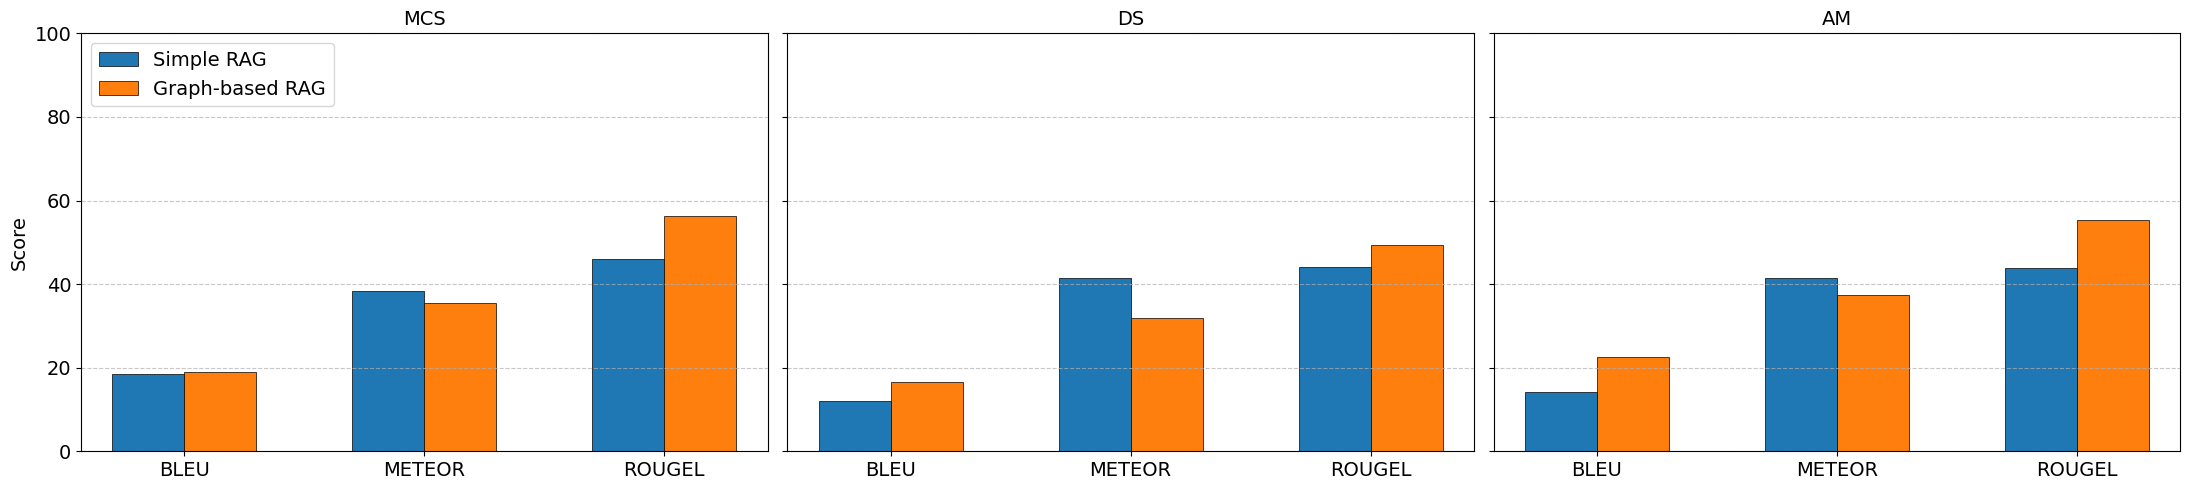

In [8]:
import pandas as pd
import numpy as np
import os
import json
from matplotlib import pyplot as plt

# Định nghĩa mapping và thứ tự metric CHUẨN
metric_map = {
    "BLEU": "BLEU",
    "METEOR": "METEOR",
    "ROUGEL": "ROUGE_L"
}
metric_order = list(metric_map.keys())

# Đọc dữ liệu Graph-based RAG từ CSV
csv_data = pd.read_csv("summary_by_dataset.csv").set_index('Dataset')

# Template path
tmpl_dirpath = "output_logs/{major}_{kind_of_qa}_{postfix}"
majors = ["MCS", "DS", "AM"]
postfixes = ["hcmus_contriever_standard_rag"]
kinds_of_qa = ["multihop2"]

fontsize = 14
colors = plt.get_cmap('tab10').colors

# Khởi tạo subplot
fig, axes = plt.subplots(1, len(majors), figsize=(22, 5), sharey=True)

for idx, major in enumerate(majors):
    method_results = {}

    # --- Simple RAG ---
    for postfix in postfixes:
        method_name = "Simple RAG"
        results = {}
        for kind_of_qa in kinds_of_qa:
            dirpath = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
            results_fpath = os.path.join(dirpath, "results.json")
            if not os.path.exists(results_fpath):
                print(f"⚠️ Missing: {results_fpath}, skipping...")
                continue
            with open(results_fpath, "r", encoding="utf-8") as f:
                data = json.load(f)
            metrics_json = data.get('open_ended', {})
            for metric in metric_order:
                for k in metrics_json:
                    if k.replace("_", "").upper() == metric:
                        value = metrics_json[k]
                        results[metric] = float(value) * 100 if float(value) <= 1 else float(value)
                        break
        method_results[method_name] = results

    # --- Graph-based RAG ---
    if major in csv_data.index:
        graph_results = {}
        for metric in metric_order:
            csv_col = metric_map[metric]
            value = csv_data.loc[major, csv_col]
            graph_results[metric] = float(value) * 100 if float(value) <= 1 else float(value)
        method_results["Graph-based RAG"] = graph_results

    # --- Chuyển sang DataFrame và transpose ---
    df = pd.DataFrame(method_results)
    df_T = df.transpose()  # method x metric

    # --- Vẽ subplot ---
    n_metrics = len(df_T.columns)
    n_methods = len(df_T.index)
    bar_width = 0.3
    x = np.arange(n_metrics)
    ax = axes[idx]

    for i, method in enumerate(df_T.index):
        ax.bar(x + i * bar_width, df_T.loc[method], width=bar_width,
               label=method, color=colors[i % len(colors)],
               edgecolor='black', linewidth=0.5)

    ax.set_xticks(x + bar_width * (n_methods - 1) / 2)
    ax.set_xticklabels(df_T.columns, rotation=0, fontsize=fontsize)
    if idx == 0:
        ax.set_ylabel("Score", fontsize=fontsize)
    ax.set_title(major, fontsize=fontsize)
    ax.set_ylim(0, 100)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    if idx == 0:
        ax.legend(ncols=1, fontsize=fontsize, loc='upper left')
    else:
        ax.legend().set_visible(False)

# --- Lưu và hiển thị ---
plt.tight_layout()
os.makedirs("../results", exist_ok=True)
plt.savefig("../results/qa_bar_chart_multihop.pdf", dpi=300, bbox_inches='tight')
plt.show()


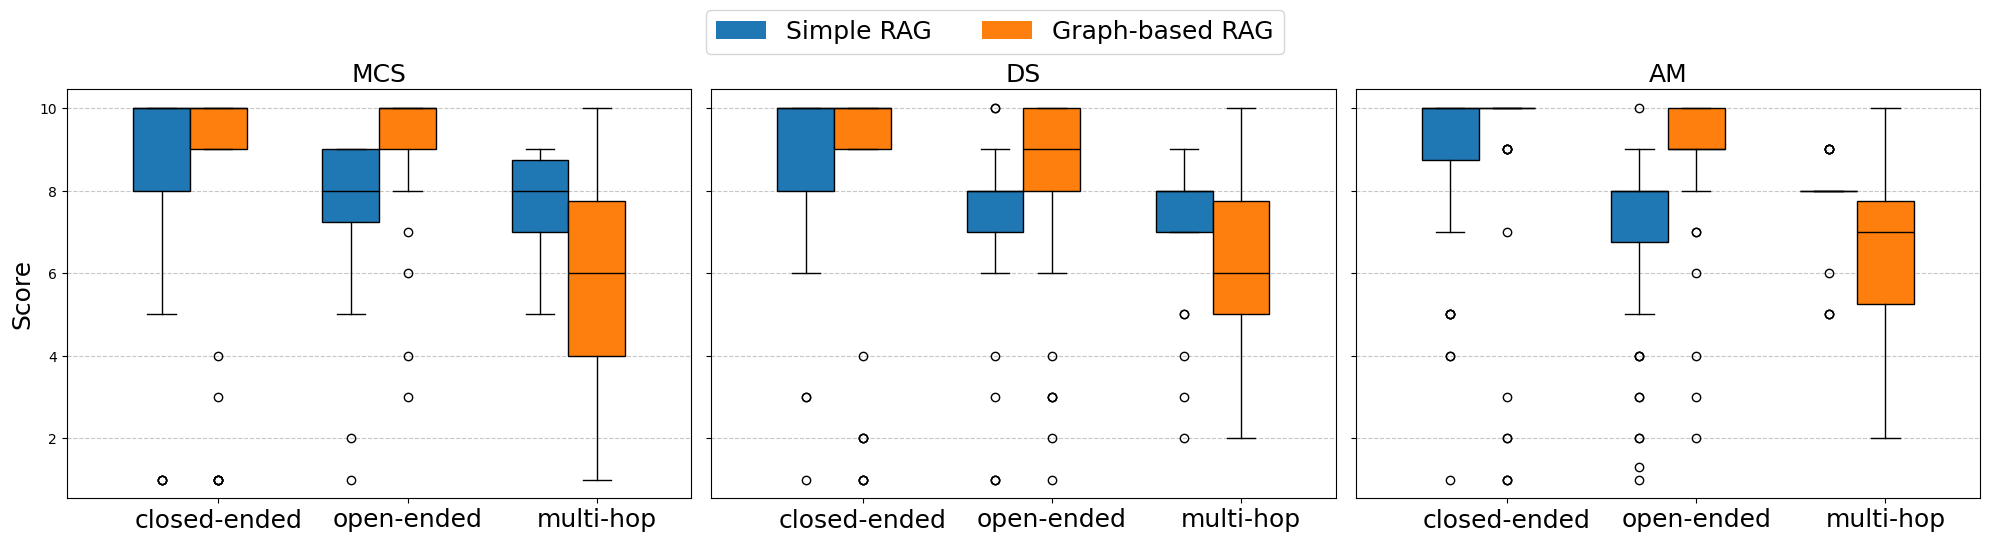

=== THỐNG KÊ TÓM TẮT ===

MCS:
  Simple RAG:
    closed_end: Mean=8.48, Std=2.62, Count=50
    opened_end: Mean=7.60, Std=1.69, Count=50
    multihop2: Mean=7.60, Std=1.30, Count=30
  Graph-based RAG:
    closed_end: Mean=8.54, Std=3.10, Count=50
    opened_end: Mean=9.24, Std=1.48, Count=50
    multihop2: Mean=6.03, Std=2.50, Count=30

DS:
  Simple RAG:
    closed_end: Mean=8.80, Std=2.15, Count=40
    opened_end: Mean=7.20, Std=2.22, Count=40
    multihop2: Mean=7.30, Std=1.80, Count=30
  Graph-based RAG:
    closed_end: Mean=8.28, Std=3.34, Count=40
    opened_end: Mean=8.00, Std=2.48, Count=40
    multihop2: Mean=6.50, Std=2.05, Count=30

AM:
  Simple RAG:
    closed_end: Mean=8.77, Std=2.08, Count=52
    opened_end: Mean=6.99, Std=2.24, Count=52
    multihop2: Mean=7.80, Std=1.10, Count=30
  Graph-based RAG:
    closed_end: Mean=8.88, Std=2.69, Count=52
    opened_end: Mean=8.77, Std=1.71, Count=52
    multihop2: Mean=6.53, Std=1.87, Count=30


In [ ]:
import pandas as pd
import numpy as np
import os
import json
from matplotlib import pyplot as plt

# Các tham số chính
majors = ["MCS", "DS", "AM"]
kinds_of_qa = ["closed_end", "opened_end", "multihop2"]
tmpl_dirpath = "output_logs/{major}_{kind_of_qa}_{postfix}"
postfix = "hcmus_contriever_standard_rag"

# 1. Đọc dữ liệu Simple RAG từ JSON
simple_records = []
for major in majors:
    for kind_of_qa in kinds_of_qa:
        path = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
        results_fpath = os.path.join(path, "results.json")
        if not os.path.exists(results_fpath):
            print(f"⚠️ Missing: {results_fpath}, skipping...")
            continue
        with open(results_fpath, "r", encoding="utf-8") as f:
            data = json.load(f)
        scores = data.get("gpt_judgement", [])
        for score in scores:
            # Xử lý các định dạng điểm khác nhau
            if isinstance(score, str):
                if score.startswith("Score: "):
                    score_value = float(score.replace("Score: ", ""))
                elif ". " in score:
                    score_value = float(score.replace(". ", "."))
                else:
                    score_value = float(score)
            else:
                score_value = float(score)
            simple_records.append({
                'method': 'Simple RAG',
                'QA Type': kind_of_qa,
                'Score': score_value,
                'major': major
            })
df_simple = pd.DataFrame(simple_records)

# 2. Đọc dữ liệu Graph-based RAG từ CSV GPT evaluation
df_gpt = pd.read_csv("gpt_evaluation_results.csv")
# Lọc các dòng hợp lệ
df_gpt = df_gpt[df_gpt['evaluation_status'] == 'success']
# Chuẩn hóa tên cột cho khớp với df_simple
df_gpt['method'] = 'Graph-based RAG'
df_gpt['QA Type'] = df_gpt['test_type']
df_gpt['Score'] = df_gpt['gpt_score']
df_gpt['major'] = df_gpt['dataset']
# Chỉ lấy các cột cần thiết
df_gpt = df_gpt[['method', 'QA Type', 'Score', 'major']]
df_gpt['Score'] = df_gpt['Score'].astype(float)

# 3. Gộp hai DataFrame lại
df_all = pd.concat([df_simple, df_gpt], ignore_index=True)

# 4. Vẽ boxplot cho từng major
fontsize = 18
fig, axes = plt.subplots(1, 3, figsize=(22, 5), sharey=True)
colors = plt.get_cmap('tab10').colors

for idx, major in enumerate(majors):
    ax = axes[idx]
    df = df_all[df_all['major'] == major]
    methods = df['method'].unique()
    for i, method in enumerate(methods):
        pos = [1 + i*0.3, 2 + i*0.3, 3 + i*0.3]
        data = [
            df[(df['method'] == method) & (df['QA Type'] == qa)]['Score']
            for qa in kinds_of_qa
        ]
        ax.boxplot(data, positions=pos, widths=0.3, patch_artist=True,
                   boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black'))
    ax.set_xticks([1 + 0.3, 2 + 0.3, 3 + 0.3])
    ax.set_xticklabels(['closed-ended', 'open-ended', 'multi-hop'], fontsize=fontsize)
    ax.set_title(major, fontsize=fontsize)
    if idx == 0:
        ax.set_ylabel('Score', fontsize=fontsize)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.legend([
    plt.Rectangle((0,0),1,1,facecolor=colors[i]) for i in range(len(methods))
], methods, loc='upper center', ncol=2, fontsize=fontsize, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
plt.savefig("../results/gpt4_judgement_boxplot_combined.pdf", dpi=300, bbox_inches='tight')
plt.show()

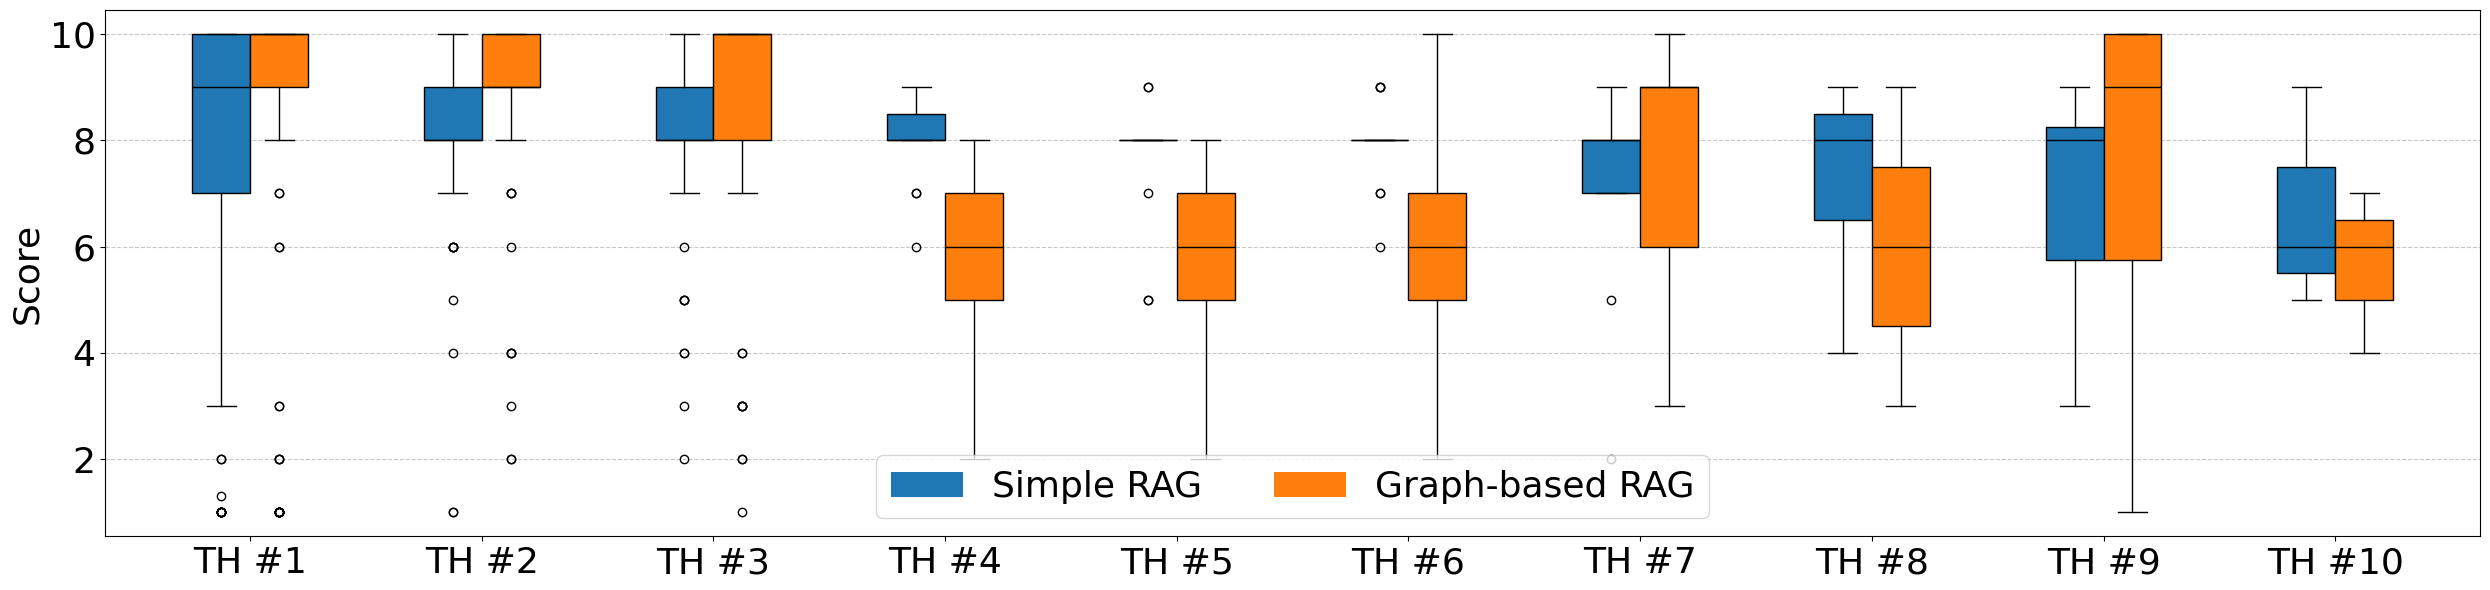


THỐNG KÊ CHI TIẾT THEO CASE STUDIES

TH #1:
  Simple RAG:
    Count: 152
    Mean: 7.890
    Std: 2.659
    Min: 1.000
    Max: 10.000
  Graph-based RAG:
    Count: 152
    Mean: 8.651
    Std: 2.761
    Min: 1.000
    Max: 10.000

TH #2:
  Simple RAG:
    Count: 81
    Mean: 8.037
    Std: 1.636
    Min: 1.000
    Max: 10.000
  Graph-based RAG:
    Count: 81
    Mean: 8.840
    Std: 1.842
    Min: 2.000
    Max: 10.000

TH #3:
  Simple RAG:
    Count: 51
    Mean: 8.098
    Std: 1.912
    Min: 2.000
    Max: 10.000
  Graph-based RAG:
    Count: 51
    Mean: 8.373
    Std: 2.715
    Min: 1.000
    Max: 10.000

TH #4:
  Simple RAG:
    Count: 15
    Mean: 8.000
    Std: 0.816
    Min: 6.000
    Max: 9.000
  Graph-based RAG:
    Count: 15
    Mean: 5.933
    Std: 1.482
    Min: 2.000
    Max: 8.000

TH #5:
  Simple RAG:
    Count: 15
    Mean: 7.667
    Std: 1.135
    Min: 5.000
    Max: 9.000
  Graph-based RAG:
    Count: 15
    Mean: 5.600
    Std: 1.818
    Min: 2.000
    Max: 8.000


In [ ]:
import pandas as pd
import numpy as np
import os
import json
from matplotlib import pyplot as plt

# Các tham số chính
majors = ["MCS", "DS", "AM"]
kinds_of_qa = ["closed_end", "opened_end", "multihop2"]
tmpl_dirpath = "output_logs/{major}_{kind_of_qa}_{postfix}"
postfix = "hcmus_contriever_standard_rag"

# 1. Đọc dữ liệu Simple RAG từ JSON và mapping với case_std_id
simple_case_results = {f"TH #{i}": {"Simple RAG": []} for i in range(1, 11)}

for major in majors:
    for kind_of_qa in kinds_of_qa:
        # Đọc kết quả Simple RAG
        path = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
        results_fpath = os.path.join(path, "results.json")
        if not os.path.exists(results_fpath):
            print(f"⚠️ Missing: {results_fpath}, skipping...")
            continue
        
        # Đọc file QA data để mapping case_std_id
        qa_data_path = f"../QA for testing/{major}/{major}_{kind_of_qa}.json"
        if not os.path.exists(qa_data_path):
            print(f"⚠️ Missing QA data: {qa_data_path}, skipping...")
            continue
        
        # Đọc dữ liệu Simple RAG
        with open(results_fpath, "r", encoding="utf-8") as f:
            results = json.load(f)
        
        # Lấy scores từ gpt_judgement
        scores = results.get("gpt_judgement", [])
        
        # Đọc QA data
        with open(qa_data_path, "r", encoding="utf-8") as f:
            qa_data = json.load(f)
        
        # Mapping scores với case_std_id
        for i, (score, qa_item) in enumerate(zip(scores, qa_data)):
            case_std_id = qa_item.get('case_std_id', 1)
            
            # Xử lý score
            if isinstance(score, str):
                if score.startswith("Score: "):
                    score_value = float(score.replace("Score: ", ""))
                elif ". " in score:
                    score_value = float(score.replace(". ", "."))
                else:
                    score_value = float(score)
            else:
                score_value = float(score)
            
            # Thêm vào kết quả
            if 1 <= case_std_id <= 10:
                simple_case_results[f"TH #{case_std_id}"]["Simple RAG"].append(score_value)

# 2. Đọc dữ liệu Graph-based RAG từ CSV và mapping với case_std_id
csv_data = pd.read_csv("gpt_evaluation_results.csv")
graph_case_results = {f"TH #{i}": {"Graph-based RAG": []} for i in range(1, 11)}

for major in majors:
    for kind_of_qa in kinds_of_qa:
        # Lọc dữ liệu CSV theo major và kind_of_qa
        major_data = csv_data[
            (csv_data["dataset"] == major) & 
            (csv_data["test_type"] == kind_of_qa) &
            (csv_data["evaluation_status"] == "success")
        ]
        
        if major_data.empty:
            print(f"⚠️ No data for {major}_{kind_of_qa}")
            continue
        
        # Đọc file QA data để mapping case_std_id
        qa_data_path = f"../QA for testing/{major}/{major}_{kind_of_qa}.json"
        if not os.path.exists(qa_data_path):
            print(f"⚠️ Missing QA data: {qa_data_path}, skipping...")
            continue
        
        with open(qa_data_path, "r", encoding="utf-8") as f:
            qa_data = json.load(f)
        
        # Tạo mapping từ question_id đến case_std_id
        question_to_case = {}
        for qa_item in qa_data:
            question_to_case[qa_item["id"]] = qa_item["case_std_id"]
        
        # Mapping kết quả Graph-based RAG với case_std_id
        for _, row in major_data.iterrows():
            question_id = row.get("question_id", "")
            if question_id in question_to_case:
                case_id = question_to_case[question_id]
                case_name = f"TH #{case_id}"
                if case_name in graph_case_results:
                    graph_case_results[case_name]["Graph-based RAG"].append(row.get("gpt_score", 0))

# 3. Gộp dữ liệu và chuẩn bị cho vẽ biểu đồ
all_case_results = {}
for case_name in simple_case_results.keys():
    all_case_results[case_name] = {
        "Simple RAG": simple_case_results[case_name]["Simple RAG"],
        "Graph-based RAG": graph_case_results[case_name]["Graph-based RAG"]
    }

# 4. Vẽ boxplot với cách vẽ và màu sắc như yêu cầu
fontsize = 26
case_studies = list(all_case_results.keys())
methods = ['Simple RAG', 'Graph-based RAG']
n_case_studies = len(case_studies)
n_methods = len(methods)
width = 0.25

fig, ax = plt.subplots(figsize=(2.5*n_case_studies, 6))

positions = []
data = []
for i, cs in enumerate(case_studies):
    for j, method in enumerate(methods):
        positions.append(i + j*width)
        data.append(all_case_results[cs][method])

# Plot each box
for i in range(n_case_studies):
    for j, method in enumerate(methods):
        pos = i + j*width
        ax.boxplot(
            all_case_results[case_studies[i]][method],
            positions=[pos],
            widths=width,
            patch_artist=True,
            boxprops=dict(facecolor=['#1f77b4', '#ff7f0e'][j]),
            medianprops=dict(color='black')
        )

# Set x-ticks in the center of each group
group_centers = [i + width/2 for i in range(n_case_studies)]
ax.set_xticks(group_centers)
ax.set_xticklabels(case_studies, rotation=0, fontsize=fontsize)
ax.set_ylabel('Score', fontsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Legend
handles = [plt.Rectangle((0,0),1,1,facecolor=c) for c in ['#1f77b4', '#ff7f0e']]
ax.legend(handles, methods, fontsize=fontsize, loc='lower center', ncol=2)

plt.tight_layout()
plt.savefig("../results/case_study_grouped_boxplot.pdf", dpi=300, bbox_inches='tight')
plt.show()